# AI-ClientProject-4 --> Quora Question Pairs

### PROJECT GOAL
##### Create a model that can predict which of the provided pairs of questions contain two questions with the same meaning.

In [20]:
# Installing libraries which are needed for loading, processing, and modeling our question-pair data.
!pip install -q pandas numpy scikit-learn sentence-transformers

In [82]:
# 📦 Data Handling
import pandas as pd
import numpy as np

# 🧮 Utility Tools
from tqdm import tqdm                     # Progress bar for loops
import warnings                           # Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🤗 Text Embedding / Feature Extraction
from sentence_transformers import SentenceTransformer

# 🧠 Similarity & Metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

# 🧪 Model Training & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# 💾 Model Saving/Loading
import joblib

In [22]:
#This step loads and reduces the dataset to a manageable size and ensures data quality.
df = pd.read_csv("train.csv") #Load the data
df = df.sample(40000, random_state=42) #Randomly selects 20,000 rows to make training faster.
df = df.dropna() #Removes rows with missing values (essential to avoid errors during training).
df = df[['question1', 'question2', 'is_duplicate']] #Keeps only the relevant columns.
df.head() #Displays the first 5 rows (useful for inspection).

,question1,question2,is_duplicate
8067,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,How close we are to see 3rd world war?,How close is a World War III?,1


In [23]:
#Counts how many duplicate vs. non-duplicate pairs exist
df['is_duplicate'].value_counts()

is_duplicate
0    25224
1    14776
Name: count, dtype: int64

<Axes: xlabel='is_duplicate'>

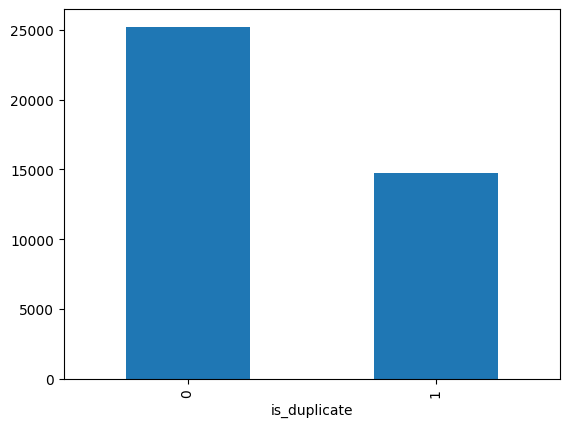

In [24]:
#Bar plot showing how many duplicate (1) vs. non-duplicate (0) question pairs exist.
df['is_duplicate'].value_counts().plot(kind='bar')

In [25]:
#This step transforms each question pair into numerical features that can be fed to a machine learning model.
embedder = SentenceTransformer('all-mpnet-base-v2')

In [26]:
def extract_features(q1, q2):
    # 🔤 Generate sentence embeddings
    vec1 = embedder.encode([q1])
    vec2 = embedder.encode([q2])

    # 📏 Compute cosine similarity between embeddings
    cos_sim = cosine_similarity(vec1, vec2)[0][0]

    # 🔡 Token-based features
    tokens1 = set(q1.lower().split())
    tokens2 = set(q2.lower().split())

    # 🔁 Common words ratio
    common_words_ratio = len(tokens1 & tokens2) / max(len(tokens1 | tokens2), 1)

    # 📏 Absolute character length difference
    abs_len_diff = abs(len(q1) - len(q2))

    return [cos_sim, common_words_ratio, abs_len_diff]

In [27]:
# Extract features
features = []
for q1, q2 in tqdm(zip(df['question1'], df['question2']), total=len(df)):
    features.append(extract_features(q1, q2))

100%|██████████| 40000/40000 [59:18<00:00, 11.24it/s]  


In [57]:
# Convert to DataFrame
X = pd.DataFrame(features, columns=["cos_sim", "common_words_ratio", "abs_len_diff"])
y = df['is_duplicate'].values

In [58]:
#Splits data into 80% training and 20% testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP Classifier": MLPClassifier(max_iter=300),
}

In [ ]:
results = []

for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        result = {
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
        }
        results.append(result)
    except Exception as e:
        print(f"Model {name} failed with error: {e}")




## **Model Evaluation**

In [62]:
# Create DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
display(results_df)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
2,Gradient Boosting,0.839250,0.755507,0.830208,0.791098,0.916075
4,MLP Classifier,0.836250,0.749616,0.830890,0.788163,0.912862
1,Random Forest,0.818000,0.741103,0.773952,0.757171,0.897816
0,Logistic Regression,0.814625,0.690890,0.894647,0.779676,0.903997
3,K-Nearest Neighbors,0.811750,0.730682,0.770542,0.750083,0.878961


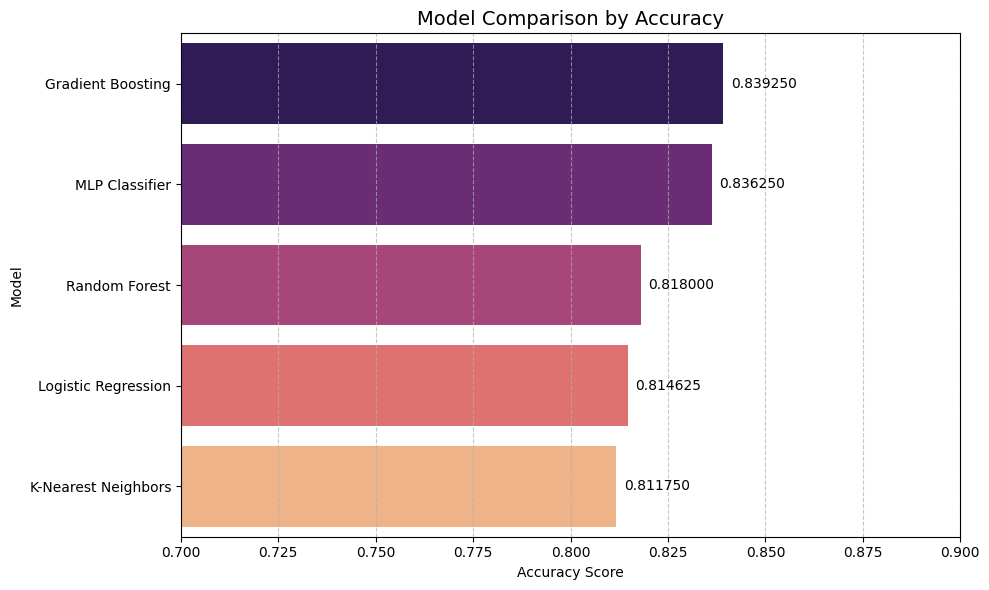

In [81]:
# Set the plot style
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Accuracy", y="Model", hue="Model", data=results_df, palette="magma", legend=False)

# Add labels and title
plt.title("Model Comparison by Accuracy", fontsize=14)
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.xlim(0.7, 0.9)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add accuracy values on bars
for i, (accuracy, model) in enumerate(zip(results_df["Accuracy"], results_df["Model"])):
    ax.text(accuracy + 0.002, i, f"{accuracy:.6f}", color='black', va='center', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


In [63]:
# Find best model based on F1 Score
best_result = max(results, key=lambda x: x["F1 Score"])
best_model_name = best_result["Model"]
print(f"Best model: {best_model_name}")

Best model: Gradient Boosting


In [64]:
# Retrieve the trained model object
best_model = models[best_model_name]

In [65]:
# Save the best model
joblib.dump(best_model, "best_model.pkl")
print("Best model saved as best_model.pkl")

Best model saved as best_model.pkl


In [66]:
# Load the saved model
loaded_model = joblib.load("best_model.pkl")

In [ ]:
#Predict whether two questions are duplicates using the trained model.

def predict_duplicate(q1, q2):
    # Extract features and reshape for model input
    features = np.array(extract_features(q1, q2)).reshape(1, -1)

    # Predict using the trained model
    pred = loaded_model.predict_proba(features)[0][1]
    label = "Duplicate" if pred >= 0.5 else "Not Duplicate"

    # Return human-readable result
    return f"{label} (Confidence Value: {pred:.2f})"


## **Testing The Performance Of Our Model**
##### Note: - If Confidence Value is below 0.5 then the Model will Predict the result as not Duplicate

In [68]:
print(predict_duplicate("How can I be a good programmer?", "What should I do to become a great coder?"))

Duplicate (Confidence Value: 0.50)


In [69]:
print(predict_duplicate("How can I be a good software engineer?", "What are the tips to become a successful software engineer?"))

Duplicate (Confidence Value: 0.82)


In [70]:
print(predict_duplicate("How can I be a good software engineer?", "What are the tips to become a successful data engineer?"))

Not Duplicate (Confidence Value: 0.11)


In [71]:
print(predict_duplicate("Is photosynthesis same as respiration?", "Is respiration same as photosynthesis?"))

Duplicate (Confidence Value: 0.96)


In [72]:
examples = [
    ("How can I learn machine learning?", "What is the best way to study machine learning?"),
    ("What is the capital of France?", "Where is the Eiffel Tower located?"),
    ("How do I cook pasta?", "What is the recipe to boil pasta?"),
    ("What are some good books to read?", "Can you suggest me a playlist of top songs?"),
    ("Why is the sky blue?", "Why does the sky appear blue in color?")
]

# Run predictions
for q1, q2 in examples:
    result = predict_duplicate(q1, q2)
    print(f"Q1: {q1}\nQ2: {q2}\n→ Prediction: {result}\n")

Q1: How can I learn machine learning?
Q2: What is the best way to study machine learning?
→ Prediction: Duplicate (Confidence Value: 0.65)

Q1: What is the capital of France?
Q2: Where is the Eiffel Tower located?
→ Prediction: Not Duplicate (Confidence Value: 0.13)

Q1: How do I cook pasta?
Q2: What is the recipe to boil pasta?
→ Prediction: Not Duplicate (Confidence Value: 0.44)

Q1: What are some good books to read?
Q2: Can you suggest me a playlist of top songs?
→ Prediction: Not Duplicate (Confidence Value: 0.00)

Q1: Why is the sky blue?
Q2: Why does the sky appear blue in color?
→ Prediction: Duplicate (Confidence Value: 0.72)



## **Testing on Custom User Input**

In [ ]:
# User Input Test
q1 = input("Enter the first question: ")
q2 = input("Enter the second question: ")

result = predict_duplicate(q1, q2)
print(f"Q1: {q1}\nQ2: {q2}\n→ Prediction: {result}\n")

Q1: How close we are to see 4th world war?
Q2: How close is a World War IV?
→ Prediction: Duplicate (Confidence Value: 0.72)

The questions are: Duplicate (Confidence Value: 0.72)
